In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Language Processing (Gensim)
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

# Dictionary & Corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

from gensim.models.ldamodel import LdaModel

import os

In [2]:
mckinsey = pd.read_csv ('.\\data_work\\mckin_textdf.csv')

In [3]:
ey = pd.read_csv ('.\\data_work\\ey_textdf.csv')

In [4]:
bcg = pd.read_csv ('.\\data_work\\bcg_textdf.csv')

In [5]:
aidata = pd.concat([mckinsey, ey, bcg])

In [12]:
len(aidata)

139

In [13]:
print(mckinsey['text'][:5])

0     in 1953 us senators grilled general motors ce...
1     the rise of artificial intelligence ai is one...
2     artificial intelligence ai is proving to be a...
3                                                     
4     the growing use of artificial intelligence in...
Name: text, dtype: object


In [14]:
aidata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 19
Data columns (total 2 columns):
title    139 non-null object
text     139 non-null object
dtypes: object(2)
memory usage: 3.3+ KB


In [18]:
from nltk.tokenize import word_tokenize

In [19]:
# Importing stopwords
stopwords_en = stopwords.words('english')


In [20]:
# And now let us make it ready for use.
wordnet_lemmatizer = WordNetLemmatizer()


In [21]:
clean_ai = aidata['text'].map(lambda t: word_tokenize(t))

In [22]:
clean_ai = clean_ai.map(lambda t: [word.lower().strip() for word in t if word.isalpha()])

In [23]:
# lemmatize and removing stopwords
clean_ai = clean_ai.map(
    lambda t: [wordnet_lemmatizer.lemmatize(word) for word in t 
               if word not in stopwords_en])

In [28]:
clean_ai.head()

0    [u, senator, grilled, general, motor, ceo, cha...
1    [rise, artificial, intelligence, ai, one, defi...
2    [artificial, intelligence, ai, proving, double...
3                                                   []
4    [growing, use, artificial, intelligence, sensi...
Name: text, dtype: object

## Bigrams (old version)

In [24]:
#from gensim.models import Phrases

In [25]:
#bigram = Phrases(clean_ai, min_count=1, delimiter=b' ')

In [26]:
#for sent in clean_ai:
    bigrams_ = [b for b in bigram[sent] if b.count(' ') == 1]

In [24]:
#len(bigrams_)

['robotic process', 'automation rpa', 'artificial intelligence', 'quick win', 'industry banking', 'support function', 'systematically incorporating', 'service organization', 'increase productivity', 'generate insight', 'establish clear', 'business objective', 'optimization effort', 'change management', 'operational function', 'rise robot', 'recent year', 'service organization', 'allows software', 'performed human', 'routine task', 'make mistake', 'reduce cost', 'manual work', 'better worse', 'timeconsuming costly', 'integration however', 'hot topic', 'service organization', 'rpa software', 'overly complex', 'accelerate process', 'started using', 'back forth', 'contract term', 'despite benefit', 'expressed concern', 'job loss', 'affected employee', 'rpa software', 'occur human', 'introduced rpa', 'call center', 'fully automated', 'automated process', 'even ambitious', 'reached new', 'increasingly embedded', 'leave virtual', 'join real', 'implication future', 'competitive advantage', 'le

## Erstat unigrams med hyppige bigrams

Følgende finder hyppigste bigrams i corpus og erstatter unigrams med bigram i `clean_ai`

In [29]:
# Konverterer serie til samlet ordliste

con_words = list(clean_ai)

con_wordlist = []
for sublist in con_words:
    for item in sublist:
        con_wordlist.append(item)

In [30]:
# Udleder hyppigste bigrams med nltk.collocations. De hyppigste 10% af bigrams beholdes (con_bi_filt)

import nltk
from nltk import word_tokenize
from nltk.collocations import BigramAssocMeasures

bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(con_wordlist)
scored = finder.score_ngrams(bigram_measures.raw_freq)

con_bi_sorted = sorted(scored, key=lambda s: s[1], reverse=True)
con_bi_filt = con_bi_sorted[0:round((0.10*len(con_bi_sorted)))]
print(len(con_bi_sorted),
     len(con_bi_filt))

94584 9458


In [31]:
#con_bi_filt er en tuple med overflødig information. Konverteres til liste af bigrams

con_bi_list = [item[0] for item in list(con_bi_filt)]
con_bi_list = [list(item) for item in con_bi_list]
con_bi_list = [item[0] + " " + item[1] for item in con_bi_list]

In [32]:
#Definerer funktion til at erstatte unigram med bigram

def bigram_insert(tokenlist, bigramlist):    
    for i in range(0, len(tokenlist)-1):
        bigram = tokenlist[i] + " " + tokenlist[i+1]
        if bigram in bigramlist:
            tokenlist[i] = bigram
            tokenlist[i+1] = ""
    tokenlist = list(filter(None, tokenlist))
    return(tokenlist)

In [33]:
#Anvender funktion bigram_insert på clean_ai og erstatter

clean_ai = clean_ai.apply(lambda row: bigram_insert(row, con_bi_list))

In [34]:
clean_ai.head()

0    [u, senator, grilled, general motor, ceo, char...
1    [rise, artificial intelligence, ai one, defini...
2    [artificial intelligence, ai, proving, doublee...
3                                                   []
4    [growing, use artificial, intelligence, sensit...
Name: text, dtype: object

In [35]:
dictionary = Dictionary(clean_ai)
corpus = [dictionary.doc2bow(word) for word in clean_ai]
print(corpus[10][:10])

[(0, 1), (8, 1), (16, 3), (23, 1), (26, 2), (27, 1), (28, 1), (34, 1), (41, 4), (51, 1)]


In [36]:
tfidf = TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]
print(tfidf_corpus[:5])

# LDA-Model

In [37]:
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [39]:
# LDA model - 5 topics
lda_model_5 = LdaModel(tfidf_corpus, id2word= dictionary,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
lda_model_5.print_topics()

[(0,
  '0.000*"reshaping business" + 0.000*"infographic" + 0.000*"survey executive" + 0.000*"intelligence work" + 0.000*"putting artificial" + 0.000*"discussed" + 0.000*"boston consulting" + 0.000*"conducted" + 0.000*"consulting group" + 0.000*"discussion experimentation"'),
 (1,
  '0.000*"ai scale" + 0.000*"fielding" + 0.000*"infographic" + 0.000*"business get" + 0.000*"learn bcg" + 0.000*"conducted interview" + 0.000*"survey executive" + 0.000*"company aim" + 0.000*"boston consulting" + 0.000*"pioneering"'),
 (2,
  '0.000*"based mckinseys" + 0.000*"stamp" + 0.000*"partner london" + 0.000*"mckinsey publishing" + 0.000*"simon" + 0.000*"chris wigley" + 0.000*"section" + 0.000*"audio" + 0.000*"click" + 0.000*"london"'),
 (3,
  '0.000*"vat return" + 0.000*"superfluid market" + 0.000*"rpa solution" + 0.000*"q" + 0.000*"south africa" + 0.000*"oil gas" + 0.000*"roy" + 0.000*"filing" + 0.000*"client china" + 0.000*"morale"'),
 (4,
  '0.000*"take win" + 0.000*"vendor" + 0.000*"health care" + 0

In [41]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model_5.log_perplexity(tfidf_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_5, texts=clean_ai, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -12.154969042463536

Coherence Score:  0.6060670300376894


In [39]:
lda_model_10 = LdaModel(tfidf_corpus, id2word= dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_10.log_perplexity(tfidf_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_10, texts=clean_ai, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -15.144051360379912

Coherence Score:  0.498030417639501


In [41]:
lda_model_10.show_topics(formatted=False)

[(0,
  [('tom', 5.771368e-05),
   ('coalition', 5.771355e-05),
   ('threetime', 5.7713525e-05),
   ('pulitzer', 5.7713456e-05),
   ('friedman', 5.7713285e-05),
   ('columnist', 5.7713143e-05),
   ('affair', 5.7713103e-05),
   ('prosperity', 5.598489e-05),
   ('thomas', 5.5923854e-05),
   ('chairman', 5.497029e-05)]),
 (1,
  [('port', 5.3432475e-05),
   ('vessel', 5.3380834e-05),
   ('trusted ai', 5.335106e-05),
   ('cathy cobey', 5.334966e-05),
   ('vessel movement', 5.3330536e-05),
   ('arrival time', 5.3330514e-05),
   ('stakeholder impact', 5.3328782e-05),
   ('risk foresight', 5.3328597e-05),
   ('machinery', 5.3324315e-05),
   ('tax authority', 5.3321182e-05)]),
 (2,
  [('uil', 5.4046028e-05),
   ('wealth asset', 5.383693e-05),
   ('wealth service', 5.3813692e-05),
   ('hyperpersonalization', 5.3707947e-05),
   ('uils', 5.3411666e-05),
   ('deliverable', 5.3305834e-05),
   ('wholesaler', 5.3304604e-05),
   ('revamp', 5.330252e-05),
   ('usha', 5.330144e-05),
   ('mark wightman', 5

In [42]:
lda_model_15 = LdaModel(tfidf_corpus, id2word= dictionary,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [43]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_15.log_perplexity(tfidf_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_15, texts=clean_ai, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.952868800116985

Coherence Score:  0.4825720669565


In [44]:
lda_model_20 = LdaModel(tfidf_corpus, id2word= dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_20.log_perplexity(tfidf_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_20, texts=clean_ai, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -26.11531940126384

Coherence Score:  0.4012591218185702


In [ ]:
topics = lda_model_20.show_topics(formatted=False)

# wordcloud 1

In [63]:
topic1 = dict(lda_model_5.show_topic(0, 50))

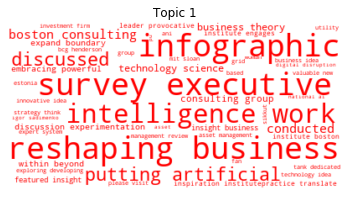

In [67]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
# Generate a word cloud image
wordcloud = WordCloud(color_func=lambda *args, **kwargs: "red", background_color="white").fit_words(topic1)
# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Topic 1')
plt.axis("off")
plt.show()


In [165]:
plt.savefig('topic1.jpg', dpi=300, format='jpg')

<Figure size 432x288 with 0 Axes>

In [166]:
wordcloud.to_file('/Users/Signe/Desktop/CALDISS_AI/topic1.jpg')

# Wordcloud 2

In [44]:
topic2 = dict(lda_model_5.show_topic(1, 50))

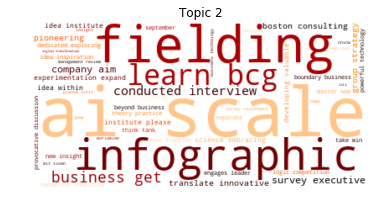

In [168]:
# Generate a word cloud image
wordcloud = WordCloud(colormap="gist_heat", background_color="white").fit_words(topic2)
# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Topic 2')
plt.axis("off")
plt.show()

In [169]:
plt.savefig('topic2.jpg', dpi=300, format='jpg')
wordcloud.to_file('/Users/Signe/Desktop/CALDISS_AI/topic2.jpg')

<Figure size 432x288 with 0 Axes>

# Wordcloud 3

In [45]:
topic3 = dict(lda_model_5.show_topic(2, 50))

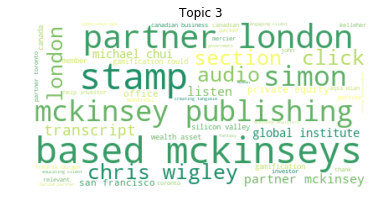

In [171]:
# Generate a word cloud image
wordcloud = WordCloud(colormap="summer", background_color="white").fit_words(topic3)
# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Topic 3')
plt.axis("off")
plt.show()

In [172]:
plt.savefig('topic3.jpg', dpi=300, format='jpg')
wordcloud.to_file('/Users/Signe/Desktop/CALDISS_AI/topic3.jpg')

<Figure size 432x288 with 0 Axes>

# Wordcloud 4

In [46]:
topic4 = dict(lda_model_5.show_topic(3, 50))

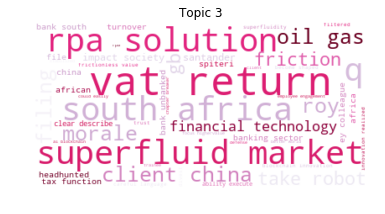

In [174]:
# Generate a word cloud image
wordcloud = WordCloud(colormap="PuRd", background_color="white").fit_words(topic4)
# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Topic 3')
plt.axis("off")
plt.show()

In [175]:
plt.savefig('topic4.jpg', dpi=300, format='jpg')
wordcloud.to_file('/Users/Signe/Desktop/CALDISS_AI/topic4.jpg')

<Figure size 432x288 with 0 Axes>

# Wordcloud 5

In [47]:
topic5 = dict(lda_model_5.show_topic(4, 50))

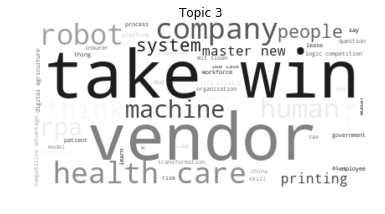

In [177]:
# Generate a word cloud image
wordcloud = WordCloud(colormap="binary", background_color="white").fit_words(topic5)
# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Topic 3')
plt.axis("off")
plt.show()

In [178]:
plt.savefig('topic5.jpg', dpi=300, format='jpg')
wordcloud.to_file('/Users/Signe/Desktop/CALDISS_AI/topic5.jpg')

<Figure size 432x288 with 0 Axes>

## Most likely words per topic (spreadsheet)

In [61]:
topic1series = pd.Series(list(topic1), index = range(0, 50), name = 'topic1')
topic2series = pd.Series(list(topic2), index = range(0, 50), name = 'topic2')
topic3series = pd.Series(list(topic3), index = range(0, 50), name = 'topic3')
topic4series = pd.Series(list(topic4), index = range(0, 50), name = 'topic4')
topic5series = pd.Series(list(topic5), index = range(0, 50), name = 'topic5')

topicwords_df = pd.concat([topic1series, topic2series, topic3series, topic4series, topic5series], axis = 1)

topicwords_df

topicwords_df.to_csv('.\\output\\aiframing_topic_words.csv')